### This jupyter notebook employs a fully connective neural network(FC) or its alias artificial neural network (ANN) to learn the mapping between demanded magnetic field between current configuration

In [59]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
from early_stopping import EarlyStopping

if torch.cuda.device_count():
    device = 'cuda'
    use_gpu = True
    print('Good to go')
else:
    device = 'cpu'
    use_gpu = False
    print('Using cpu')

Using cpu


In [72]:
from ReadData import ReadCurrentAndField 
import glob
import os 

# print(os.getcwd())
foldername="./Data/"
filepattern = "MagneticField[0-9]*.txt"
#data = ReadFolder(foldername,filepattern)
load_file_num = 1460
train_file_num = 1000
grid_size = 21
data = ReadCurrentAndField (foldername,filepattern, load_file_num)


data=data.reshape(load_file_num,grid_size,grid_size,grid_size,18)
mask = torch.cat((torch.ones(1,1,1,1,12),1e3*torch.ones(1,1,1,1,6)), dim=4)
# position unit mm, B field unit mT, Current unit Ampere
data = mask*data

sparsity = 4

Position_Bfield =data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,12:].reshape(-1,6) 
Current = data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:12].reshape(-1,12) 

print(np.abs(Position_Bfield[:,3:]).mean())
print(data.shape)
print('position Bfield shape', Position_Bfield.shape)
print('Current shape', Current.shape)


tensor(12.8117)
torch.Size([1460, 21, 21, 21, 18])
position Bfield shape torch.Size([216000, 6])
Current shape torch.Size([216000, 12])


In [75]:
from Neural_network import NN_net, Plain_fc_block, weight_init, eMNS_Dataset
from Training_loop_v2 import train_ANN
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer, TorchConfig
from ray.tune.tuner import Tuner
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import ray, os
import torch.nn.functional as F

# construct dataset

Position_Bfield =data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,12:].reshape(-1,6) 

Current = data[:train_file_num,0::sparsity,0::sparsity,0::sparsity,:12].reshape(-1,12)

dataset = eMNS_Dataset(
    x=Position_Bfield,
    y=Current
)

# split the dataset to train, validation, test
train_set, valid_set = torch.utils.data.random_split(dataset, [0.9,0.1])

# normailzation
extremes = dataset.train_norm_ANN(train_indices = train_set.indices, boundary_index=3)

###############################################
# Config the neural network
###############################################
num_input = 6
num_output = 12
fc_stages = [(num_input,100,1),(100,50,1),(50,25,1)]
fc_network = NN_net(None,fc_stages,None,Plain_fc_block, num_output=num_output)


model_path = r"./Trained_model/EMS_ANN_v2.pt"
forward_model = torch.load(model_path)['model'].to(device)
forward_model.eval()

loss_func = lambda current, Bfield, position: F.mse_loss(current, torch.zeros_like(current)) + F.l1_loss(Bfield, forward_model(torch.cat((current, position), axis =1)))


################################################
# Train the neural network
################################################

train_loop_config = {
                'epochs': 50,
                'lr_max': 1e-4,
                'lr_min': 2.5e-7,
                'batch_size': 128,
                'L2_norm'   : 0,
                'verbose': False,
                'schedule': [],
                'learning_rate_decay': 0.5,
                'num_input'   : num_input,
                'num_output'  : num_output,
                'fc_stages'   : fc_stages,
                'backward'    : True,
                'maxB'        : extremes[2],
                'minB'        : extremes[3],
                'maxC'        : extremes[4],
                'minC'        : extremes[5],
                'device'      : device,
                'train_set'   : train_set,
                'valid_set'   : valid_set,
                'loss_func'   : loss_func,
                'forward_model': forward_model
                # You can even grid search various datasets in Tune.
                # "datasets": tune.grid_search(
                #         [ds1, ds2]
                #     ),
}

scaling_config = ScalingConfig(
    num_workers = 1,
    use_gpu = use_gpu,
    # resources_per_worker={"CPU":1, "GPU":1}
)

run_config = RunConfig(name="EMS_ANN_backward_v2",checkpoint_config=CheckpointConfig(num_to_keep=1))


# for windows
# torch_config = TorchConfig(backend="nccl")
trainer = TorchTrainer(
    train_loop_per_worker = train_ANN,
    train_loop_config = train_loop_config,
    scaling_config = scaling_config,
    run_config = run_config,
    # torch_config= torch_config # for windows

)
result = trainer.fit()



(TorchTrainer pid=60095) Started distributed worker processes: 
(TorchTrainer pid=60095) - (ip=192.168.8.117, pid=60146) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=60146) Setting up process group for: env:// [rank=0, world_size=1]


(RayTrainWorker pid=60146) Epoch 0, Iteration 1519, loss = 0.0958
(RayTrainWorker pid=60146) Got rmse 3.695441484451294


(RayTrainWorker pid=60146) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/ray_results/EMS_ANN_backward_v2/TorchTrainer_ab4f2_00000_0_2024-04-18_17-54-38/checkpoint_000000)


(RayTrainWorker pid=60146) Got rmse 3.686203718185425
(RayTrainWorker pid=60146) 


2024-04-18 17:54:57,456	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.171 s, which may be a performance bottleneck.
2024-04-18 17:54:57,458	WARNING util.py:202 -- The `process_trial_result` operation took 2.173 s, which may be a performance bottleneck.
2024-04-18 17:54:57,459	WARNING util.py:202 -- Processing trial results took 2.173 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:54:57,459	WARNING util.py:202 -- The `process_trial_result` operation took 2.174 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 1, Iteration 3038, loss = 0.0918
(RayTrainWorker pid=60146) Got rmse 2.98016095161438
(RayTrainWorker pid=60146) Got rmse 2.9657533168792725
(RayTrainWorker pid=60146) 


2024-04-18 17:55:01,425	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.257 s, which may be a performance bottleneck.
2024-04-18 17:55:01,427	WARNING util.py:202 -- The `process_trial_result` operation took 2.259 s, which may be a performance bottleneck.
2024-04-18 17:55:01,427	WARNING util.py:202 -- Processing trial results took 2.259 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:01,428	WARNING util.py:202 -- The `process_trial_result` operation took 2.260 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 2, Iteration 4557, loss = 0.0835
(RayTrainWorker pid=60146) Got rmse 2.6902709007263184
(RayTrainWorker pid=60146) Got rmse 2.674171209335327
(RayTrainWorker pid=60146) 


2024-04-18 17:55:05,207	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.283 s, which may be a performance bottleneck.
2024-04-18 17:55:05,210	WARNING util.py:202 -- The `process_trial_result` operation took 2.286 s, which may be a performance bottleneck.
2024-04-18 17:55:05,210	WARNING util.py:202 -- Processing trial results took 2.286 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:05,211	WARNING util.py:202 -- The `process_trial_result` operation took 2.287 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 3, Iteration 6076, loss = 0.0775
(RayTrainWorker pid=60146) Got rmse 2.5311193466186523
(RayTrainWorker pid=60146) Got rmse 2.5129129886627197
(RayTrainWorker pid=60146) 


2024-04-18 17:55:09,586	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.810 s, which may be a performance bottleneck.
2024-04-18 17:55:09,588	WARNING util.py:202 -- The `process_trial_result` operation took 2.813 s, which may be a performance bottleneck.
2024-04-18 17:55:09,589	WARNING util.py:202 -- Processing trial results took 2.813 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:09,589	WARNING util.py:202 -- The `process_trial_result` operation took 2.814 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 4, Iteration 7595, loss = 0.0861
(RayTrainWorker pid=60146) Got rmse 2.460908889770508
(RayTrainWorker pid=60146) Got rmse 2.4407458305358887
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 5, Iteration 9114, loss = 0.0806
(RayTrainWorker pid=60146) Got rmse 2.4033055305480957


2024-04-18 17:55:15,297	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.003 s, which may be a performance bottleneck.
2024-04-18 17:55:15,300	WARNING util.py:202 -- The `process_trial_result` operation took 3.007 s, which may be a performance bottleneck.
2024-04-18 17:55:15,301	WARNING util.py:202 -- Processing trial results took 3.007 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:15,301	WARNING util.py:202 -- The `process_trial_result` operation took 3.008 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.380995988845825
(RayTrainWorker pid=60146) 


2024-04-18 17:55:20,102	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.985 s, which may be a performance bottleneck.
2024-04-18 17:55:20,103	WARNING util.py:202 -- The `process_trial_result` operation took 2.987 s, which may be a performance bottleneck.
2024-04-18 17:55:20,104	WARNING util.py:202 -- Processing trial results took 2.988 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:20,104	WARNING util.py:202 -- The `process_trial_result` operation took 2.988 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 6, Iteration 10633, loss = 0.0826
(RayTrainWorker pid=60146) Got rmse 2.351086139678955
(RayTrainWorker pid=60146) Got rmse 2.3275067806243896
(RayTrainWorker pid=60146) 


2024-04-18 17:55:25,461	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.801 s, which may be a performance bottleneck.
2024-04-18 17:55:25,465	WARNING util.py:202 -- The `process_trial_result` operation took 2.805 s, which may be a performance bottleneck.
2024-04-18 17:55:25,466	WARNING util.py:202 -- Processing trial results took 2.805 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:25,466	WARNING util.py:202 -- The `process_trial_result` operation took 2.807 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 7, Iteration 12152, loss = 0.0869
(RayTrainWorker pid=60146) Got rmse 2.3022637367248535
(RayTrainWorker pid=60146) Got rmse 2.278052568435669
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 8, Iteration 13671, loss = 0.0720
(RayTrainWorker pid=60146) Got rmse 2.289518117904663


2024-04-18 17:55:30,986	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.919 s, which may be a performance bottleneck.
2024-04-18 17:55:30,990	WARNING util.py:202 -- The `process_trial_result` operation took 2.923 s, which may be a performance bottleneck.
2024-04-18 17:55:30,990	WARNING util.py:202 -- Processing trial results took 2.923 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:30,991	WARNING util.py:202 -- The `process_trial_result` operation took 2.924 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.264834403991699
(RayTrainWorker pid=60146) 


2024-04-18 17:55:35,649	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.802 s, which may be a performance bottleneck.
2024-04-18 17:55:35,650	WARNING util.py:202 -- The `process_trial_result` operation took 2.804 s, which may be a performance bottleneck.
2024-04-18 17:55:35,651	WARNING util.py:202 -- Processing trial results took 2.805 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:35,652	WARNING util.py:202 -- The `process_trial_result` operation took 2.806 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 9, Iteration 15190, loss = 0.0825
(RayTrainWorker pid=60146) Got rmse 2.2774667739868164
(RayTrainWorker pid=60146) Got rmse 2.2522575855255127
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 10, Iteration 16709, loss = 0.0786


2024-04-18 17:55:41,067	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.798 s, which may be a performance bottleneck.
2024-04-18 17:55:41,070	WARNING util.py:202 -- The `process_trial_result` operation took 2.802 s, which may be a performance bottleneck.
2024-04-18 17:55:41,071	WARNING util.py:202 -- Processing trial results took 2.803 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:41,072	WARNING util.py:202 -- The `process_trial_result` operation took 2.804 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.261758804321289
(RayTrainWorker pid=60146) Got rmse 2.2355802059173584
(RayTrainWorker pid=60146) 


2024-04-18 17:55:46,039	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.085 s, which may be a performance bottleneck.
2024-04-18 17:55:46,041	WARNING util.py:202 -- The `process_trial_result` operation took 3.087 s, which may be a performance bottleneck.
2024-04-18 17:55:46,043	WARNING util.py:202 -- Processing trial results took 3.089 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:46,043	WARNING util.py:202 -- The `process_trial_result` operation took 3.090 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 11, Iteration 18228, loss = 0.0744
(RayTrainWorker pid=60146) Got rmse 2.23686146736145
(RayTrainWorker pid=60146) Got rmse 2.2116329669952393
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 12, Iteration 19747, loss = 0.0841
(RayTrainWorker pid=60146) Got rmse 2.213682174682617


2024-04-18 17:55:51,457	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.787 s, which may be a performance bottleneck.
2024-04-18 17:55:51,460	WARNING util.py:202 -- The `process_trial_result` operation took 2.790 s, which may be a performance bottleneck.
2024-04-18 17:55:51,461	WARNING util.py:202 -- Processing trial results took 2.791 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:51,461	WARNING util.py:202 -- The `process_trial_result` operation took 2.792 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1889443397521973
(RayTrainWorker pid=60146) 


2024-04-18 17:55:56,145	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.864 s, which may be a performance bottleneck.
2024-04-18 17:55:56,147	WARNING util.py:202 -- The `process_trial_result` operation took 2.866 s, which may be a performance bottleneck.
2024-04-18 17:55:56,147	WARNING util.py:202 -- Processing trial results took 2.867 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:55:56,148	WARNING util.py:202 -- The `process_trial_result` operation took 2.867 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 13, Iteration 21266, loss = 0.0840
(RayTrainWorker pid=60146) Got rmse 2.213188409805298
(RayTrainWorker pid=60146) Got rmse 2.1871707439422607
(RayTrainWorker pid=60146) 


2024-04-18 17:56:01,564	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.879 s, which may be a performance bottleneck.
2024-04-18 17:56:01,567	WARNING util.py:202 -- The `process_trial_result` operation took 2.882 s, which may be a performance bottleneck.
2024-04-18 17:56:01,568	WARNING util.py:202 -- Processing trial results took 2.883 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:01,568	WARNING util.py:202 -- The `process_trial_result` operation took 2.884 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 14, Iteration 22785, loss = 0.0877
(RayTrainWorker pid=60146) Got rmse 2.2031567096710205
(RayTrainWorker pid=60146) Got rmse 2.1774582862854004
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 15, Iteration 24304, loss = 0.0717
(RayTrainWorker pid=60146) Got rmse 2.2118406295776367


2024-04-18 17:56:07,552	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.261 s, which may be a performance bottleneck.
2024-04-18 17:56:07,556	WARNING util.py:202 -- The `process_trial_result` operation took 3.265 s, which may be a performance bottleneck.
2024-04-18 17:56:07,556	WARNING util.py:202 -- Processing trial results took 3.266 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:07,557	WARNING util.py:202 -- The `process_trial_result` operation took 3.267 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1870293617248535
(RayTrainWorker pid=60146) 


2024-04-18 17:56:12,244	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.837 s, which may be a performance bottleneck.
2024-04-18 17:56:12,247	WARNING util.py:202 -- The `process_trial_result` operation took 2.841 s, which may be a performance bottleneck.
2024-04-18 17:56:12,248	WARNING util.py:202 -- Processing trial results took 2.841 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:12,248	WARNING util.py:202 -- The `process_trial_result` operation took 2.843 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 16, Iteration 25823, loss = 0.0777
(RayTrainWorker pid=60146) Got rmse 2.1957249641418457
(RayTrainWorker pid=60146) Got rmse 2.1715352535247803
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 17, Iteration 27342, loss = 0.0868
(RayTrainWorker pid=60146) Got rmse 2.2209391593933105


2024-04-18 17:56:17,665	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.859 s, which may be a performance bottleneck.
2024-04-18 17:56:17,669	WARNING util.py:202 -- The `process_trial_result` operation took 2.863 s, which may be a performance bottleneck.
2024-04-18 17:56:17,670	WARNING util.py:202 -- Processing trial results took 2.864 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:17,671	WARNING util.py:202 -- The `process_trial_result` operation took 2.865 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.195918560028076
(RayTrainWorker pid=60146) 


2024-04-18 17:56:22,373	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.914 s, which may be a performance bottleneck.
2024-04-18 17:56:22,375	WARNING util.py:202 -- The `process_trial_result` operation took 2.916 s, which may be a performance bottleneck.
2024-04-18 17:56:22,376	WARNING util.py:202 -- Processing trial results took 2.918 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:22,377	WARNING util.py:202 -- The `process_trial_result` operation took 2.919 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 18, Iteration 28861, loss = 0.0816
(RayTrainWorker pid=60146) Got rmse 2.184135675430298
(RayTrainWorker pid=60146) Got rmse 2.1602485179901123
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 19, Iteration 30380, loss = 0.0879


2024-04-18 17:56:27,950	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.839 s, which may be a performance bottleneck.
2024-04-18 17:56:27,953	WARNING util.py:202 -- The `process_trial_result` operation took 2.842 s, which may be a performance bottleneck.
2024-04-18 17:56:27,954	WARNING util.py:202 -- Processing trial results took 2.843 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:27,955	WARNING util.py:202 -- The `process_trial_result` operation took 2.845 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.182620048522949
(RayTrainWorker pid=60146) Got rmse 2.1586995124816895
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 20, Iteration 31899, loss = 0.0768
(RayTrainWorker pid=60146) Got rmse 2.1878695487976074


2024-04-18 17:56:33,415	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.893 s, which may be a performance bottleneck.
2024-04-18 17:56:33,418	WARNING util.py:202 -- The `process_trial_result` operation took 2.896 s, which may be a performance bottleneck.
2024-04-18 17:56:33,418	WARNING util.py:202 -- Processing trial results took 2.897 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:33,419	WARNING util.py:202 -- The `process_trial_result` operation took 2.898 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.163586139678955
(RayTrainWorker pid=60146) 


2024-04-18 17:56:38,051	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.817 s, which may be a performance bottleneck.
2024-04-18 17:56:38,054	WARNING util.py:202 -- The `process_trial_result` operation took 2.820 s, which may be a performance bottleneck.
2024-04-18 17:56:38,055	WARNING util.py:202 -- Processing trial results took 2.821 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:38,055	WARNING util.py:202 -- The `process_trial_result` operation took 2.822 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 21, Iteration 33418, loss = 0.0771
(RayTrainWorker pid=60146) Got rmse 2.1747570037841797
(RayTrainWorker pid=60146) Got rmse 2.1508774757385254
(RayTrainWorker pid=60146) 


2024-04-18 17:56:43,592	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.952 s, which may be a performance bottleneck.
2024-04-18 17:56:43,595	WARNING util.py:202 -- The `process_trial_result` operation took 2.955 s, which may be a performance bottleneck.
2024-04-18 17:56:43,596	WARNING util.py:202 -- Processing trial results took 2.956 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:43,596	WARNING util.py:202 -- The `process_trial_result` operation took 2.957 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 22, Iteration 34937, loss = 0.0824
(RayTrainWorker pid=60146) Got rmse 2.188861131668091
(RayTrainWorker pid=60146) Got rmse 2.16521954536438
(RayTrainWorker pid=60146) 


2024-04-18 17:56:48,323	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.846 s, which may be a performance bottleneck.
2024-04-18 17:56:48,325	WARNING util.py:202 -- The `process_trial_result` operation took 2.848 s, which may be a performance bottleneck.
2024-04-18 17:56:48,326	WARNING util.py:202 -- Processing trial results took 2.849 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:48,327	WARNING util.py:202 -- The `process_trial_result` operation took 2.850 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 23, Iteration 36456, loss = 0.0838
(RayTrainWorker pid=60146) Got rmse 2.1744883060455322
(RayTrainWorker pid=60146) Got rmse 2.1510212421417236
(RayTrainWorker pid=60146) 


2024-04-18 17:56:53,687	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.796 s, which may be a performance bottleneck.
2024-04-18 17:56:53,690	WARNING util.py:202 -- The `process_trial_result` operation took 2.799 s, which may be a performance bottleneck.
2024-04-18 17:56:53,691	WARNING util.py:202 -- Processing trial results took 2.800 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:53,692	WARNING util.py:202 -- The `process_trial_result` operation took 2.802 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 24, Iteration 37975, loss = 0.0767
(RayTrainWorker pid=60146) Got rmse 2.189133405685425
(RayTrainWorker pid=60146) Got rmse 2.166337728500366
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 25, Iteration 39494, loss = 0.0719


2024-04-18 17:56:59,286	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.960 s, which may be a performance bottleneck.
2024-04-18 17:56:59,290	WARNING util.py:202 -- The `process_trial_result` operation took 2.964 s, which may be a performance bottleneck.
2024-04-18 17:56:59,290	WARNING util.py:202 -- Processing trial results took 2.965 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:56:59,291	WARNING util.py:202 -- The `process_trial_result` operation took 2.966 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1719305515289307
(RayTrainWorker pid=60146) Got rmse 2.149822473526001
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 26, Iteration 41013, loss = 0.0876
(RayTrainWorker pid=60146) Got rmse 2.16776442527771


2024-04-18 17:57:04,669	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.799 s, which may be a performance bottleneck.
2024-04-18 17:57:04,673	WARNING util.py:202 -- The `process_trial_result` operation took 2.803 s, which may be a performance bottleneck.
2024-04-18 17:57:04,674	WARNING util.py:202 -- Processing trial results took 2.804 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:04,675	WARNING util.py:202 -- The `process_trial_result` operation took 2.805 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1452715396881104
(RayTrainWorker pid=60146) 


2024-04-18 17:57:09,297	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.766 s, which may be a performance bottleneck.
2024-04-18 17:57:09,299	WARNING util.py:202 -- The `process_trial_result` operation took 2.768 s, which may be a performance bottleneck.
2024-04-18 17:57:09,299	WARNING util.py:202 -- Processing trial results took 2.769 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:09,300	WARNING util.py:202 -- The `process_trial_result` operation took 2.770 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 27, Iteration 42532, loss = 0.0774
(RayTrainWorker pid=60146) Got rmse 2.176663398742676
(RayTrainWorker pid=60146) Got rmse 2.1542389392852783
(RayTrainWorker pid=60146) 


2024-04-18 17:57:14,848	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.938 s, which may be a performance bottleneck.
2024-04-18 17:57:14,851	WARNING util.py:202 -- The `process_trial_result` operation took 2.941 s, which may be a performance bottleneck.
2024-04-18 17:57:14,852	WARNING util.py:202 -- Processing trial results took 2.942 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:14,853	WARNING util.py:202 -- The `process_trial_result` operation took 2.944 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 28, Iteration 44051, loss = 0.0755
(RayTrainWorker pid=60146) Got rmse 2.167637348175049
(RayTrainWorker pid=60146) Got rmse 2.1451687812805176
(RayTrainWorker pid=60146) 


2024-04-18 17:57:19,581	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.804 s, which may be a performance bottleneck.
2024-04-18 17:57:19,582	WARNING util.py:202 -- The `process_trial_result` operation took 2.806 s, which may be a performance bottleneck.
2024-04-18 17:57:19,583	WARNING util.py:202 -- Processing trial results took 2.807 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:19,584	WARNING util.py:202 -- The `process_trial_result` operation took 2.808 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 29, Iteration 45570, loss = 0.0777
(RayTrainWorker pid=60146) Got rmse 2.165848970413208
(RayTrainWorker pid=60146) Got rmse 2.143064498901367
(RayTrainWorker pid=60146) 


2024-04-18 17:57:24,951	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.798 s, which may be a performance bottleneck.
2024-04-18 17:57:24,955	WARNING util.py:202 -- The `process_trial_result` operation took 2.803 s, which may be a performance bottleneck.
2024-04-18 17:57:24,956	WARNING util.py:202 -- Processing trial results took 2.804 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:24,957	WARNING util.py:202 -- The `process_trial_result` operation took 2.805 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 30, Iteration 47089, loss = 0.0716
(RayTrainWorker pid=60146) Got rmse 2.171369791030884
(RayTrainWorker pid=60146) Got rmse 2.148609161376953
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 31, Iteration 48608, loss = 0.0764


2024-04-18 17:57:30,497	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.930 s, which may be a performance bottleneck.
2024-04-18 17:57:30,501	WARNING util.py:202 -- The `process_trial_result` operation took 2.934 s, which may be a performance bottleneck.
2024-04-18 17:57:30,502	WARNING util.py:202 -- Processing trial results took 2.935 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:30,502	WARNING util.py:202 -- The `process_trial_result` operation took 2.936 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.172097682952881
(RayTrainWorker pid=60146) Got rmse 2.1495797634124756
(RayTrainWorker pid=60146) 


2024-04-18 17:57:35,149	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.856 s, which may be a performance bottleneck.
2024-04-18 17:57:35,151	WARNING util.py:202 -- The `process_trial_result` operation took 2.859 s, which may be a performance bottleneck.
2024-04-18 17:57:35,152	WARNING util.py:202 -- Processing trial results took 2.859 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:35,153	WARNING util.py:202 -- The `process_trial_result` operation took 2.860 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 32, Iteration 50127, loss = 0.0811
(RayTrainWorker pid=60146) Got rmse 2.170032262802124
(RayTrainWorker pid=60146) Got rmse 2.1478099822998047
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 33, Iteration 51646, loss = 0.0822


2024-04-18 17:57:40,788	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.907 s, which may be a performance bottleneck.
2024-04-18 17:57:40,792	WARNING util.py:202 -- The `process_trial_result` operation took 2.911 s, which may be a performance bottleneck.
2024-04-18 17:57:40,793	WARNING util.py:202 -- Processing trial results took 2.912 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:40,794	WARNING util.py:202 -- The `process_trial_result` operation took 2.913 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1589174270629883
(RayTrainWorker pid=60146) Got rmse 2.1366055011749268
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 34, Iteration 53165, loss = 0.0759
(RayTrainWorker pid=60146) Got rmse 2.170968532562256


2024-04-18 17:57:46,247	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.834 s, which may be a performance bottleneck.
2024-04-18 17:57:46,250	WARNING util.py:202 -- The `process_trial_result` operation took 2.838 s, which may be a performance bottleneck.
2024-04-18 17:57:46,251	WARNING util.py:202 -- Processing trial results took 2.838 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:46,251	WARNING util.py:202 -- The `process_trial_result` operation took 2.839 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1486849784851074
(RayTrainWorker pid=60146) 


2024-04-18 17:57:51,014	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.885 s, which may be a performance bottleneck.
2024-04-18 17:57:51,016	WARNING util.py:202 -- The `process_trial_result` operation took 2.887 s, which may be a performance bottleneck.
2024-04-18 17:57:51,017	WARNING util.py:202 -- Processing trial results took 2.888 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:51,017	WARNING util.py:202 -- The `process_trial_result` operation took 2.889 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 35, Iteration 54684, loss = 0.0744
(RayTrainWorker pid=60146) Got rmse 2.163430690765381
(RayTrainWorker pid=60146) Got rmse 2.1411588191986084
(RayTrainWorker pid=60146) 


2024-04-18 17:57:56,443	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.821 s, which may be a performance bottleneck.
2024-04-18 17:57:56,446	WARNING util.py:202 -- The `process_trial_result` operation took 2.825 s, which may be a performance bottleneck.
2024-04-18 17:57:56,447	WARNING util.py:202 -- Processing trial results took 2.826 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:57:56,448	WARNING util.py:202 -- The `process_trial_result` operation took 2.827 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 36, Iteration 56203, loss = 0.0827
(RayTrainWorker pid=60146) Got rmse 2.1717562675476074
(RayTrainWorker pid=60146) Got rmse 2.1497068405151367
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 37, Iteration 57722, loss = 0.0750
(RayTrainWorker pid=60146) Got rmse 2.162935256958008


2024-04-18 17:58:01,891	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.861 s, which may be a performance bottleneck.
2024-04-18 17:58:01,894	WARNING util.py:202 -- The `process_trial_result` operation took 2.864 s, which may be a performance bottleneck.
2024-04-18 17:58:01,895	WARNING util.py:202 -- Processing trial results took 2.865 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:01,896	WARNING util.py:202 -- The `process_trial_result` operation took 2.866 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1412508487701416
(RayTrainWorker pid=60146) 


2024-04-18 17:58:06,689	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.956 s, which may be a performance bottleneck.
2024-04-18 17:58:06,691	WARNING util.py:202 -- The `process_trial_result` operation took 2.958 s, which may be a performance bottleneck.
2024-04-18 17:58:06,692	WARNING util.py:202 -- Processing trial results took 2.959 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:06,692	WARNING util.py:202 -- The `process_trial_result` operation took 2.960 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 38, Iteration 59241, loss = 0.0718
(RayTrainWorker pid=60146) Got rmse 2.1734797954559326
(RayTrainWorker pid=60146) Got rmse 2.1511778831481934
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 39, Iteration 60760, loss = 0.0668


2024-04-18 17:58:12,114	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.904 s, which may be a performance bottleneck.
2024-04-18 17:58:12,117	WARNING util.py:202 -- The `process_trial_result` operation took 2.908 s, which may be a performance bottleneck.
2024-04-18 17:58:12,117	WARNING util.py:202 -- Processing trial results took 2.908 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:12,118	WARNING util.py:202 -- The `process_trial_result` operation took 2.909 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1650030612945557
(RayTrainWorker pid=60146) Got rmse 2.1431427001953125
(RayTrainWorker pid=60146) 


2024-04-18 17:58:16,806	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.848 s, which may be a performance bottleneck.
2024-04-18 17:58:16,807	WARNING util.py:202 -- The `process_trial_result` operation took 2.849 s, which may be a performance bottleneck.
2024-04-18 17:58:16,807	WARNING util.py:202 -- Processing trial results took 2.850 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:16,809	WARNING util.py:202 -- The `process_trial_result` operation took 2.852 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 40, Iteration 62279, loss = 0.0790
(RayTrainWorker pid=60146) Got rmse 2.167266845703125
(RayTrainWorker pid=60146) Got rmse 2.145524263381958
(RayTrainWorker pid=60146) 


2024-04-18 17:58:22,243	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.883 s, which may be a performance bottleneck.
2024-04-18 17:58:22,248	WARNING util.py:202 -- The `process_trial_result` operation took 2.888 s, which may be a performance bottleneck.
2024-04-18 17:58:22,249	WARNING util.py:202 -- Processing trial results took 2.889 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:22,249	WARNING util.py:202 -- The `process_trial_result` operation took 2.890 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 41, Iteration 63798, loss = 0.0724
(RayTrainWorker pid=60146) Got rmse 2.1662027835845947
(RayTrainWorker pid=60146) Got rmse 2.1442134380340576
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 42, Iteration 65317, loss = 0.0804


2024-04-18 17:58:27,772	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.921 s, which may be a performance bottleneck.
2024-04-18 17:58:27,776	WARNING util.py:202 -- The `process_trial_result` operation took 2.925 s, which may be a performance bottleneck.
2024-04-18 17:58:27,776	WARNING util.py:202 -- Processing trial results took 2.926 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:27,777	WARNING util.py:202 -- The `process_trial_result` operation took 2.927 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1656646728515625
(RayTrainWorker pid=60146) Got rmse 2.143786668777466
(RayTrainWorker pid=60146) 


2024-04-18 17:58:32,488	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.833 s, which may be a performance bottleneck.
2024-04-18 17:58:32,489	WARNING util.py:202 -- The `process_trial_result` operation took 2.835 s, which may be a performance bottleneck.
2024-04-18 17:58:32,491	WARNING util.py:202 -- Processing trial results took 2.837 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:32,492	WARNING util.py:202 -- The `process_trial_result` operation took 2.838 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 43, Iteration 66836, loss = 0.0696
(RayTrainWorker pid=60146) Got rmse 2.164680242538452
(RayTrainWorker pid=60146) Got rmse 2.1428773403167725
(RayTrainWorker pid=60146) 


2024-04-18 17:58:37,896	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.850 s, which may be a performance bottleneck.
2024-04-18 17:58:37,900	WARNING util.py:202 -- The `process_trial_result` operation took 2.854 s, which may be a performance bottleneck.
2024-04-18 17:58:37,901	WARNING util.py:202 -- Processing trial results took 2.855 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:37,902	WARNING util.py:202 -- The `process_trial_result` operation took 2.856 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 44, Iteration 68355, loss = 0.0766
(RayTrainWorker pid=60146) Got rmse 2.1626837253570557
(RayTrainWorker pid=60146) Got rmse 2.1409201622009277
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 45, Iteration 69874, loss = 0.0703


2024-04-18 17:58:43,367	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.825 s, which may be a performance bottleneck.
2024-04-18 17:58:43,370	WARNING util.py:202 -- The `process_trial_result` operation took 2.829 s, which may be a performance bottleneck.
2024-04-18 17:58:43,371	WARNING util.py:202 -- Processing trial results took 2.829 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:43,371	WARNING util.py:202 -- The `process_trial_result` operation took 2.830 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1612467765808105
(RayTrainWorker pid=60146) Got rmse 2.139524459838867
(RayTrainWorker pid=60146) 


2024-04-18 17:58:48,037	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.786 s, which may be a performance bottleneck.
2024-04-18 17:58:48,038	WARNING util.py:202 -- The `process_trial_result` operation took 2.788 s, which may be a performance bottleneck.
2024-04-18 17:58:48,040	WARNING util.py:202 -- Processing trial results took 2.789 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:48,040	WARNING util.py:202 -- The `process_trial_result` operation took 2.790 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 46, Iteration 71393, loss = 0.0685
(RayTrainWorker pid=60146) Got rmse 2.162552833557129
(RayTrainWorker pid=60146) Got rmse 2.140679359436035
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 47, Iteration 72912, loss = 0.0787


2024-04-18 17:58:53,404	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.783 s, which may be a performance bottleneck.
2024-04-18 17:58:53,408	WARNING util.py:202 -- The `process_trial_result` operation took 2.788 s, which may be a performance bottleneck.
2024-04-18 17:58:53,409	WARNING util.py:202 -- Processing trial results took 2.789 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:53,410	WARNING util.py:202 -- The `process_trial_result` operation took 2.790 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1624436378479004
(RayTrainWorker pid=60146) Got rmse 2.1406190395355225
(RayTrainWorker pid=60146) 
(RayTrainWorker pid=60146) Epoch 48, Iteration 74431, loss = 0.0799
(RayTrainWorker pid=60146) Got rmse 2.1622605323791504


2024-04-18 17:58:59,080	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 3.050 s, which may be a performance bottleneck.
2024-04-18 17:58:59,084	WARNING util.py:202 -- The `process_trial_result` operation took 3.054 s, which may be a performance bottleneck.
2024-04-18 17:58:59,085	WARNING util.py:202 -- Processing trial results took 3.055 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:58:59,086	WARNING util.py:202 -- The `process_trial_result` operation took 3.056 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Got rmse 2.1404712200164795
(RayTrainWorker pid=60146) 


2024-04-18 17:59:03,831	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.860 s, which may be a performance bottleneck.
2024-04-18 17:59:03,833	WARNING util.py:202 -- The `process_trial_result` operation took 2.861 s, which may be a performance bottleneck.
2024-04-18 17:59:03,833	WARNING util.py:202 -- Processing trial results took 2.862 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:59:03,834	WARNING util.py:202 -- The `process_trial_result` operation took 2.864 s, which may be a performance bottleneck.


(RayTrainWorker pid=60146) Epoch 49, Iteration 75950, loss = 0.0713
(RayTrainWorker pid=60146) Got rmse 2.162307024002075


(RayTrainWorker pid=60146) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/qubot/ray_results/EMS_ANN_backward_v2/TorchTrainer_ab4f2_00000_0_2024-04-18_17-54-38/checkpoint_000001)


(RayTrainWorker pid=60146) Got rmse 2.140507221221924
(RayTrainWorker pid=60146) 


2024-04-18 17:59:08,719	WARNING util.py:202 -- The `callbacks.on_trial_result` operation took 2.331 s, which may be a performance bottleneck.
2024-04-18 17:59:08,722	WARNING util.py:202 -- The `process_trial_result` operation took 2.335 s, which may be a performance bottleneck.
2024-04-18 17:59:08,723	WARNING util.py:202 -- Processing trial results took 2.335 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-04-18 17:59:08,723	WARNING util.py:202 -- The `process_trial_result` operation took 2.336 s, which may be a performance bottleneck.
2024-04-18 17:59:11,898	INFO tune.py:1042 -- Total run time: 273.72 seconds (273.11 seconds for the tuning loop).


In [ ]:
from torchsummary import summary
summary(fc_network, (1,6))
for param_tensor in fc_network.state_dict():
    print(param_tensor, '\t', fc_network.state_dict()[param_tensor].size())

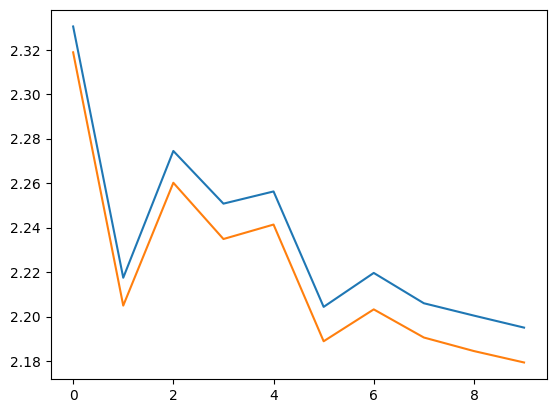

In [61]:
from utils import plot_ray_results
plot_ray_results(results=result, metrics_names = ['rmse_val','rmse_train'])

In [62]:
checkpoint_data = torch.load(os.path.join(result.checkpoint.path,"model.pt"))

model_path = r"./Trained_model/EMS_ANN_backward_v2.pt"
torch.save(checkpoint_data, model_path)

## Test dataset performance

In [63]:
extremes

(tensor(50.),
 tensor(-50.),
 tensor(63.7902),
 tensor(-65.4425),
 tensor(14.9997),
 tensor(-14.9944))

In [64]:
# position unit mm, current unit Ampere, B field unit mT
sparsity = 1
# Position_Bfield_test =data[train_file_num:, ::sparsity, ::sparsity, ::sparsity, :6].reshape(-1,6) 

# Current_test = data[train_file_num:, ::sparsity, ::sparsity, ::sparsity,:12].reshape(-1,12)

Position_Bfield_test =data[:train_file_num, ::sparsity, ::sparsity, ::sparsity, 12:].reshape(-1,6) 

Current_test = data[:train_file_num, ::sparsity, ::sparsity, ::sparsity,:12].reshape(-1,12)

num_sample = Position_Bfield_test.shape[0]
print('position Bfield shape', Position_Bfield_test.shape)
print('Current shape', Current_test.shape)

# construct dataset
test_set = eMNS_Dataset(
    x=Position_Bfield_test.clone(),
    y=Current_test
)
print(test_set.x.abs().mean())
print(Position_Bfield_test.abs().mean())
test_set.test_norm_ANN(extremes=extremes, boundary_index=3)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=train_loop_config['batch_size'],
    shuffle=False)

print(test_set.x.abs().mean())
print(Position_Bfield_test.abs().mean())

position Bfield shape torch.Size([9261000, 6])
Current shape torch.Size([9261000, 12])
tensor(19.3242)
tensor(19.3242)
tensor(0.3585)
tensor(19.3242)


In [33]:
extremes

(tensor(50.),
 tensor(-50.),
 tensor(63.7902),
 tensor(-65.4425),
 tensor(14.9997),
 tensor(-14.9944))

In [68]:
from utils import predict_check_rmse_ANN, check_rmse_ANN
from Training_loop_v2 import construct_model_ANN 

model_path = r"./Trained_model/EMS_ANN_backward_v2.pt"
backward_model = torch.load(model_path)['model']

prediction, rmse, mse, Rsquare = predict_check_rmse_ANN(test_loader, backward_model, config=train_loop_config)
# check_rmse_ANN(test_loader, backward_model, config=train_loop_config)

 current rmse: 7.632105827331543, L2 before: 909.8939819335938, L2 after backward model: 150.0493621826172
Got rmse 2.280806541442871, num_samples 9261000


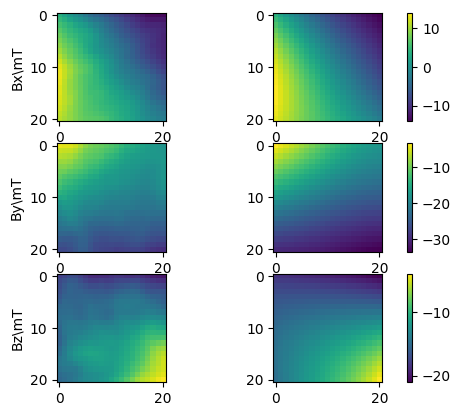

In [57]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
grid_test = int(np.ceil(grid_size/sparsity))
B_est = prediction.reshape(-1, grid_test, grid_test, grid_test, 3)

Bfield_test = Position_Bfield_test[:,3:].reshape(-1, grid_test, grid_test, grid_test, 3)
# Bfield_test = data[train_file_num:,:,:,:,15:]

current_index=50
z_plane_index= 4
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
ylables=['Bx\mT','By\mT','Bz\mT']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    B_est_sample = B_est[current_index,:,:,z_plane_index,i-1]
    B_desired_sample = Bfield_test[current_index,:,:,z_plane_index,i-1]
    vmin = min(B_est_sample.min(), B_desired_sample.min())
    vmax = max(B_est_sample.max(), B_desired_sample.max())
    norm = colors.Normalize(vmin=vmin, vmax=vmax) 
    ax = plt.subplot(3,2,2*i-1)
    img = plt.imshow(B_est_sample, norm=norm)    
    plt.ylabel(ylables[i-1])
    ax2 = plt.subplot(3,2,2*i)
    img2 = plt.imshow(B_desired_sample, norm=norm)
    plt.colorbar(img,ax=[ax,ax2])

plt.show()

In [ ]:
import numpy as np 
A = np.arange(21)
print(A[::4])
print(A[::1])

In [ ]:
A = torch.arange(3) + 0.0
B = A.reshape(1,3)
print(F.mse_loss(B, torch.zeros_like(B)))
print(torch.linalg.norm(B))

In [ ]:
np.sqrt(5)